# Project Notebook 
Project Topic: Network Anomaly Detection with BitNet<br><br>
Project Description: One of the main problems with machine learning models on a large scale is their resource-intensive nature. This can cause massive spikes in both energy usage and runtime, which is especially problematic in fields such as networking, where latency is of the utmost importance. Our goal with this project is to transfer the principles of BitNet, a recent model which does away with resource-intensive matrix multiplications via the quantization of weights, to a networking context. Specifically, we build a simple regression model with this method, which we will then use on a dataset of packet traces during which several intrusions were attempted.

Collaborators: Alexander Baumgartner, Alexander Williams, Alejandro Alonso

Professor: Nick Feamster

<br>

---

### Notebook Summary
This notebook evaluates the performance of different IDS models, focusing on both the standard and hardware-efficient variants. It recreates the functionality of `measure_models.py` in a notebook format and includes the integration function directly for better visibility.

<br>

---

### Packages

In [1]:
%pip install matplotlib scikit-learn pandas numpy scipy torch tqdm joblib pathlib psutil pyRapl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.0 MB/s eta 0:00:00
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pathlib-1.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached pyRAPL-0.2.3.1-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 7.7 MB/s eta 0:00:00
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.4-py3-none-an

### Setup and Initialization
*This cell imports all necessary libraries and checks for optional features like pyRAPL for energy monitoring.*

In [2]:
import time
import torch
import psutil
import platform

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_curve, auc

try:
    import pyRAPL
    PYRAPL_AVAILABLE = True
except ImportError:
    PYRAPL_AVAILABLE = False

 You need to install pymongo>=3.9.0 in order to use MongoOutput 


*This cell imports necessary models and helpers from our py scripts.*

In [3]:
from models.baseline import StandardIDS
from models.efficient_ids import EfficientIDS

from helpers.ids_processor import IDSProcessor
from helpers.data_processor import MemoryEfficientIDSDataProcessor

*This cell establishes notebook-wide constants.*

In [4]:
SAVED_MODELS_DIR = "./saved_models"

### Data Directory and Configurations
*This cell defines parameters for data loading, including the location of the dataset and the size of data chunks for processing. These settings can be adjusted as needed.*


In [5]:
data_dir = 'data/'
chunk_size = 100000
saved_model = "trained_matmulfree_model_12_11_24.pth"
epochs = 20

print("Data directory:", data_dir)

Data directory: data/


### Integration Function
*The function handles data preprocessing, training, and evaluation for the IDS models. This cell includes the definition to ensure clarity and usability within the notebook.*

In [6]:
def integrate_with_hardware_efficient_ids(
        data_dir,
        chunk_size=chunk_size,
        saved_model=saved_model,
        model_type='matmul_free',
        epochs=epochs,
        callback=None
    ):
    """
    Improved integration function with measurement callback.
    """
    print("\nInitializing data processor...")
    data_processor = MemoryEfficientIDSDataProcessor()

    print("Loading and preprocessing data...")
    try:
        X, y, feature_columns = data_processor.load_and_preprocess_data(data_dir, chunk_size)
    except Exception as e:
        raise RuntimeError(f"Error during data processing: {str(e)}")

    print("\nValidating data...")
    assert not np.isnan(X).any(), "X contains NaN values"
    assert not np.isinf(X).any(), "X contains infinite values"
    print("Data validation passed")

    print("\nSplitting data...")
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
    )

    print("\nInitializing model...")
    ids_processor = IDSProcessor()
    
    if callback:
        callback()
    
    if saved_model and Path(f'{SAVED_MODELS_DIR}/{saved_model}').exists():
        print("Loading saved model...")
        checkpoint = torch.load(f'{SAVED_MODELS_DIR}/{saved_model}', map_location=torch.device('cpu'))
        ids_processor.model = (EfficientIDS if model_type == 'matmul_free' else StandardIDS)(
            num_features=X.shape[1],
            **checkpoint['hyperparameters']
        ).to(ids_processor.device)
        print("Loading state dict...")
        ids_processor.model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Training new model...")
        def training_callback():
            if callback:
                callback()
        
        ids_processor.train_model(
            X_train, y_train,
            X_val, y_val,
            epochs=epochs,
            model_type=model_type,
            callback=training_callback
        )
        
        checkpoint = {
            'model_state_dict': ids_processor.model.state_dict(),
            'hyperparameters': ids_processor.config,
            'feature_stats': data_processor.feature_stats
        }
        torch.save(
            checkpoint,
            f'{SAVED_MODELS_DIR}/trained_{model_type}_model_{datetime.now().strftime("%m%d%Y-%H%M%S")}.pth'
        )

    if callback:
        callback()

    return ids_processor, {
        'X_test': X_test,
        'y_test': y_test,
        'feature_columns': feature_columns
    }

### Running the Models and Measuring Performance

*This section runs the models, collects performance metrics, and logs CPU and energy usage. Inline measurements are taken using callbacks, and results are structured for later analysis.*

In [8]:
results = {}

is_linux = platform.system() == 'Linux'
if PYRAPL_AVAILABLE and is_linux:
    pyRAPL.setup()
else:
    print("pyRAPL unavailable. Using CPU usage for power estimation.")

for model_type in ['matmul_free', 'standard']:
    print(f"\nRunning {model_type} model...")

    start_time = time.time()
    cpu_usage = []
    energy_meter = None

    if PYRAPL_AVAILABLE and is_linux:
        energy_meter = pyRAPL.Measurement(f"{model_type}_energy")
        energy_meter.begin()

    try:
        def measure_callback():
            cpu_percent = psutil.cpu_percent()
            cpu_usage.append(cpu_percent)

        if model_type == 'standard':
            saved_model = 'trained_standard_model.pth'
        ids_processor, test_data = integrate_with_hardware_efficient_ids(
            data_dir=data_dir,
            chunk_size=chunk_size,
            saved_model=saved_model,
            model_type=model_type,
            epochs=epochs,
            callback=measure_callback
        )

        predictions, prediction_scores = ids_processor.detect_anomalies(
            test_data['X_test'], 
            return_scores=True
        )

        precision, recall, _ = precision_recall_curve(
            test_data['y_test'],
            prediction_scores
        )
        pr_auc = auc(recall, precision)

        classification_metrics = classification_report(
            test_data['y_test'],
            predictions,
            output_dict=True
        )

    finally:
        if energy_meter:
            energy_meter.end()

    end_time = time.time()
    runtime = end_time - start_time
    peak_cpu = max(cpu_usage) if cpu_usage else 0
    avg_cpu = np.mean(cpu_usage) if cpu_usage else 0

    if energy_meter:
        energy_consumed = energy_meter.result.energy / 1e6
    else:
        tdp_watts = 65
        power_readings = [(tdp_watts * usage) / 100.0 for usage in cpu_usage]
        energy_consumed = np.mean(power_readings) * runtime if power_readings else 0

    results[model_type] = {
        'runtime_seconds': runtime,
        'peak_cpu_usage_percent': peak_cpu,
        'avg_cpu_usage_percent': avg_cpu,
        'energy_consumed_joules': energy_consumed,
        'classification_report': classification_metrics,
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'pr_auc': pr_auc,
        'cpu_usage': cpu_usage,
        'y_test': test_data['y_test'].tolist()
    }

    print(f"\n{model_type.upper()} MODEL RESULTS:")
    print(f"Runtime: {runtime:.2f} seconds")
    print(f"Peak CPU Usage: {peak_cpu:.1f}%")
    print(f"Average CPU Usage: {avg_cpu:.1f}%")
    print(f"Energy Consumed: {energy_consumed:.2f} Joules")
    print(f"PR-AUC Score: {pr_auc:.3f}")
    print("\nClassification Report:")
    for label in ['0.0', '1.0']:
        metrics = classification_metrics[label]
        print(f"\nClass {label}:")
        print(f"Precision: {metrics['precision']:.3f}")
        print(f"Recall: {metrics['recall']:.3f}")
        print(f"F1-score: {metrics['f1-score']:.3f}")

pyRAPL unavailable. Using CPU usage for power estimation.

Running matmul_free model...

Initializing data processor...
Loading and preprocessing data...

Processing Tuesday-WorkingHours.pcap_ISCX.csv...
Processed 445909 total rows
Removed 0 corrupted rows (0.00%)

Data Statistics:
Total samples: 445909

Attack distribution:
BENIGN: 432074 samples (96.90%)
FTP-Patator: 7938 samples (1.78%)
SSH-Patator: 5897 samples (1.32%)

Combining processed data...
Encoding labels...
Handling missing values in features...
Final dataset shape: (445909, 78)
Number of features: 78
Class distribution: [432074  13835]

Validating data...
Data validation passed

Splitting data...

Initializing model...
Loading saved model...
Loading state dict...


/var/folders/r4/4v8t12hd3y1253vtxg1gxdp80000gn/T/ipykernel_71311/919803221.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{SAVED_MODELS_DIR}/


MATMUL_FREE MODEL RESULTS:
Runtime: 26.75 seconds
Peak CPU Usage: 100.0%
Average CPU Usage: 74.6%
Energy Consumed: 1297.00 Joules
PR-AUC Score: 0.995

Classification Report:

Class 0.0:
Precision: 1.000
Recall: 0.997
F1-score: 0.999

Class 1.0:
Precision: 0.922
Recall: 1.000
F1-score: 0.959

Running standard model...

Initializing data processor...
Loading and preprocessing data...

Processing Tuesday-WorkingHours.pcap_ISCX.csv...
Processed 445909 total rows
Removed 0 corrupted rows (0.00%)

Data Statistics:
Total samples: 445909

Attack distribution:
BENIGN: 432074 samples (96.90%)
FTP-Patator: 7938 samples (1.78%)
SSH-Patator: 5897 samples (1.32%)

Combining processed data...
Encoding labels...
Handling missing values in features...
Final dataset shape: (445909, 78)
Number of features: 78
Class distribution: [432074  13835]

Validating data...
Data validation passed

Splitting data...

Initializing model...
Loading saved model...
Loading state dict...


/var/folders/r4/4v8t12hd3y1253vtxg1gxdp80000gn/T/ipykernel_71311/919803221.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{SAVED_MODELS_DIR}/


STANDARD MODEL RESULTS:
Runtime: 6.21 seconds
Peak CPU Usage: 73.7%
Average CPU Usage: 56.9%
Energy Consumed: 229.65 Joules
PR-AUC Score: 0.997

Classification Report:

Class 0.0:
Precision: 1.000
Recall: 0.997
F1-score: 0.999

Class 1.0:
Precision: 0.917
Recall: 0.998
F1-score: 0.956


### Results Summary
*This cell saves the results into a JSON file for reference and displays a textual summary of the collected data.*

In [9]:
import json
print(json.dumps(results, indent=2)[:500])

{
  "matmul_free": {
    "runtime_seconds": 26.747725248336792,
    "peak_cpu_usage_percent": 100.0,
    "avg_cpu_usage_percent": 74.6,
    "energy_consumed_joules": 1296.997197291851,
    "classification_report": {
      "0.0": {
        "precision": 1.0,
        "recall": 0.9972921367818087,
        "f1-score": 0.9986442327748036,
        "support": 86415.0
      },
      "1.0": {
        "precision": 0.9220259913362212,
        "recall": 1.0,
        "f1-score": 0.9594313453536755,
        "s


### Precision-Recall Visualization
*This cell generates precision-recall curves for each model, providing insights into their classification performance.*

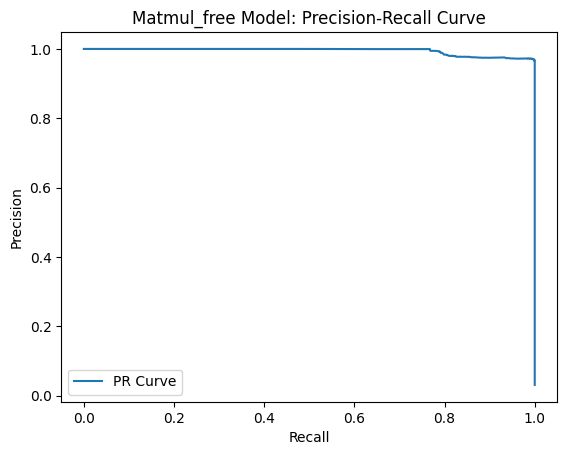

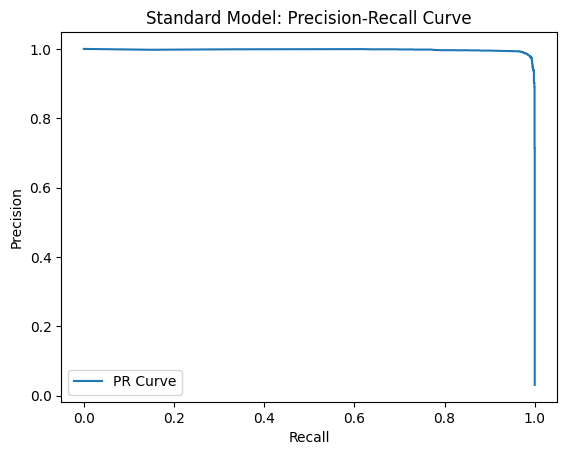

In [10]:
for model_type in results:
    plt.figure()
    plt.plot(results[model_type]['recall'], results[model_type]['precision'], label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_type.capitalize()} Model: Precision-Recall Curve')
    plt.legend()
    plt.show()

### CPU Usage Visualization
*This cell visualizes the CPU usage over time for each model, offering a perspective on computational efficiency.*

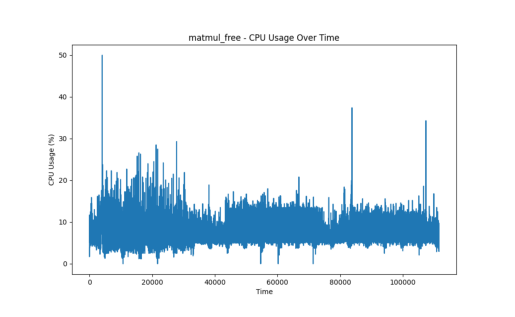

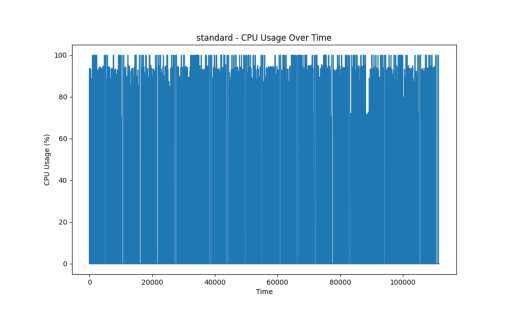

In [15]:
if not saved_model:
    for model_type in results:
        plt.figure()
        plt.plot(results[model_type]['cpu_usage'], label='CPU Usage')
        plt.xlabel('Time')
        plt.ylabel('CPU Usage (%)')
        plt.title(f'{model_type.capitalize()} Model: CPU Usage Over Time')
        plt.legend()
        plt.savefig(f'{SAVED_MODELS_DIR}/trained_{model_type}_model_{datetime.now().strftime("%m%d%Y-%H%M%S")}_cpu.png')
        plt.show()
else:
    import matplotlib.image as mpimg
    for saved_model in ["trained_matmulfree_model_12_11_24.pth", "trained_standard_model.pth"]:
        img_name = saved_model.replace('.pth', '_cpu.png')
        img = mpimg.imread(f"{SAVED_MODELS_DIR}/{img_name}")
        plt.imshow(img)
        plt.axis('off')
        plt.show()

### Confusion Matrix Visualization
*This cell visualizes the confusion matrix for each model.*

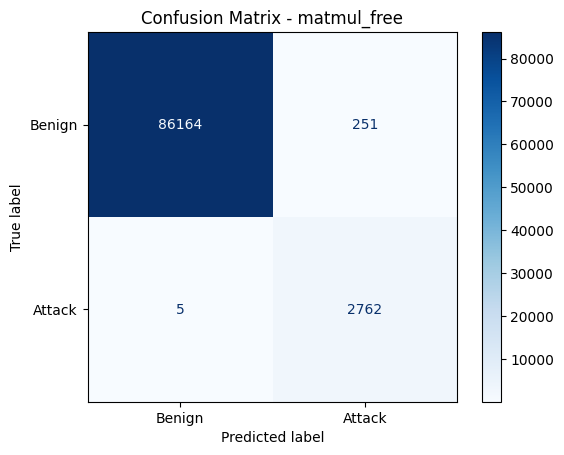

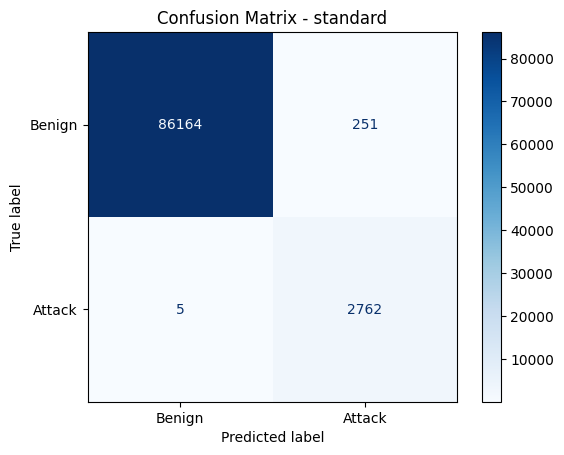

In [12]:
for model_type in results:
    cm = confusion_matrix(results[model_type]['y_test'], predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Attack"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_type}")
    plt.show()

# Conclusion

This notebook provides an executable example of IDS performance evaluation, combining the integration function with inline performance measurements and visualization.

*The notebook achieves a comprehensive evaluation of IDS models and provides actionable insights for improving intrusion detection systems.*